In [162]:
import sys, os
sys.path.append(os.path.join(sys.path[0], 'tfGCN'))

In [163]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import time
from tqdm import tqdm
import tensorflow as tf

from models import GCN, HashedGCN
from utils import *

In [165]:
# Set random seed
seed = 123

In [ ]:
# Settings
flags = tf.app.flags 
FLAGS = tf.app.flags.FLAGS
flags.DEFINE_string('dataset', 'cora', 'Dataset string.')  # 'cora', 'citeseer', 'pubmed'
flags.DEFINE_string('model', 'gcn', 'Model string.')  # 'gcn', 'gcn_cheby', 'hashed_gcn', 'dense'
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 16, 'Number of units in hidden layer 1.')
flags.DEFINE_float('dropout', 0.5, 'Dropout rate (1 - keep probability).')
flags.DEFINE_float('weight_decay', 5e-4, 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_integer('early_stopping', 10, 'Tolerance for early stopping (# of epochs).')
flags.DEFINE_integer('max_degree', 3, 'Maximum Chebyshev polynomial degree.')
flags.DEFINE_integer('compression_factor1', 1, 'Hashed GCN weight compression factor (layer 1).')
flags.DEFINE_integer('compression_factor2', 1, 'Hashed GCN weight compression factor (layer 2).')
tf.app.flags.DEFINE_string('f', '', 'kernel')

In [4]:
# Load data
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data(FLAGS.dataset)

# Some preprocessing
features = preprocess_features(features)

support = [preprocess_adj(adj)]
num_supports = 1

In [5]:
# Define placeholders
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features[2], dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

In [13]:
# Define model evaluation function
def evaluate(features, support, labels, mask, placeholders):
    t_test = time.time()
    feed_dict_val = construct_feed_dict(features, support, labels, mask, placeholders)
    outs_val = sess.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)

In [78]:
model = GCN(placeholders, input_dim=features[2][1], logging=True)

In [89]:
# Reseed
np.random.seed(seed)
tf.set_random_seed(seed)

# Initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [90]:
cost_val = []

# Train model
for epoch in range(FLAGS.epochs):
    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)

    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    cost_val.append(cost)

#     # Print results
#     print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
#           "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
#           "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and cost_val[-1] > np.mean(cost_val[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break
        
_, baseline_acc, _ = evaluate(features, support, y_test, test_mask, placeholders)
print("Baseline accuracy:", baseline_acc)

Baseline accuracy: 0.80899906


In [148]:
compression_factors = [1, 2, 4, 8, 16, 32, 64, 128]
compression_accuracies = []
num_runs = 5

for cf in tqdm(compression_factors):
    FLAGS.compression_factor1 = cf
    FLAGS.compression_factor2 = 1
    np.random.seed(seed)
    tf.set_random_seed(seed)
    all_acc = []
    
    for _ in range(num_runs):
        model = HashedGCN(placeholders, input_dim=features[2][1], logging=True)
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())

        cost_val = []
        # Train model
        for epoch in range(FLAGS.epochs):
            t = time.time()

            feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
            feed_dict.update({placeholders['dropout']: FLAGS.dropout})

            # Training step
            outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)

            # Validation
            cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
            cost_val.append(cost)

            if epoch > FLAGS.early_stopping and cost_val[-1] > np.mean(cost_val[-(FLAGS.early_stopping+1):-1]):
                break
        _, compressed_acc, _ = evaluate(features, support, y_test, test_mask, placeholders)
        all_acc.append(compressed_acc)
    compression_accuracies.append(all_acc)
compression_accuracies = np.asarray(compression_accuracies)



  0%|                                                    | 0/8 [00:00<?, ?it/s]

 12%|█████▍                                     | 1/8 [06:18<44:05, 377.94s/it]

 25%|██████████▊                                | 2/8 [12:24<37:27, 374.66s/it]

 38%|████████████████▏                          | 3/8 [19:01<31:46, 381.33s/it]

 50%|█████████████████████▌                     | 4/8 [25:37<25:42, 385.59s/it]

 62%|██████████████████████████▉                | 5/8 [32:07<19:20, 386.97s/it]

 75%|████████████████████████████████▎          | 6/8 [38:57<13:07, 393.87s/it]

 88%|█████████████████████████████████████▋     | 7/8 [45:46<06:38, 398.30s/it]

100%|███████████████████████████████████████████| 8/8 [52:30<00:00, 400.15s/it]



In [157]:
compression_accuracies_median = (1 - np.median(compression_accuracies, axis=1)) * 100
compression_accuracies_std = np.std(compression_accuracies, axis=1) * 100

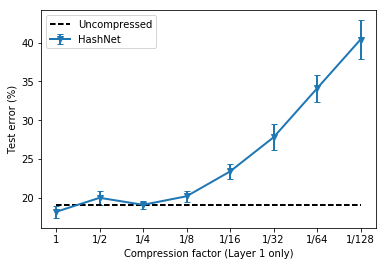

In [160]:
# Plot compression vs accuracy
x = np.arange(8)
plt.xlabel("Compression factor (Layer 1 only)")
plt.ylabel("Test error (%)")
plt.errorbar(x, compression_accuracies_median, compression_accuracies_std, \
             label="HashNet", linewidth=2.0, marker='v', capsize=3)
fig = plt.plot(x, (1 - np.repeat(baseline_acc, 8)) * 100, label="Uncompressed", linewidth=2.0, linestyle='--', color='black')
plt.xticks(x, ["1", "1/2", "1/4", "1/8", "1/16", "1/32", "1/64", "1/128"])
leg = plt.legend()

In [161]:
with open('compression_layer1.png','wb') as f:
    fig[0].figure.savefig(f, format='png', dpi=144)

In [166]:
compression_factors_base = [1, 2, 4, 8]
compression_factors_hashed = [1, 2, 4, 8, 16, 32]
num_runs = 5

base_compression_accuracies = []
both_layer_compression_accuracies = []
for cf in tqdm(compression_factors_base):
    FLAGS.hidden1 = 16 // cf
    np.random.seed(seed)
    tf.set_random_seed(seed)
    all_acc = []
    for _ in range(num_runs):
        model = GCN(placeholders, input_dim=features[2][1], logging=True)
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())

        cost_val = []
        # Train model
        for epoch in range(FLAGS.epochs):
            t = time.time()

            feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
            feed_dict.update({placeholders['dropout']: FLAGS.dropout})

            # Training step
            outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)

            # Validation
            cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
            cost_val.append(cost)

            if epoch > FLAGS.early_stopping and cost_val[-1] > np.mean(cost_val[-(FLAGS.early_stopping+1):-1]):
                break
        _, compressed_acc, _ = evaluate(features, support, y_test, test_mask, placeholders)
        all_acc.append(compressed_acc)
    base_compression_accuracies.append(all_acc)

FLAGS.hidden1 = 16
    
for cf in tqdm(compression_factors_hashed):
    FLAGS.compression_factor1 = cf
    FLAGS.compression_factor2 = cf
    np.random.seed(seed)
    tf.set_random_seed(seed)
    all_acc = []
    for _ in range(num_runs):
        model = HashedGCN(placeholders, input_dim=features[2][1], logging=True)
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())

        cost_val = []
        # Train model
        for epoch in range(FLAGS.epochs):
            t = time.time()

            feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
            feed_dict.update({placeholders['dropout']: FLAGS.dropout})

            # Training step
            outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)

            # Validation
            cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
            cost_val.append(cost)

            if epoch > FLAGS.early_stopping and cost_val[-1] > np.mean(cost_val[-(FLAGS.early_stopping+1):-1]):
                break
        _, compressed_acc, _ = evaluate(features, support, y_test, test_mask, placeholders)
        all_acc.append(compressed_acc)
    both_layer_compression_accuracies.append(all_acc)
    
base_compression_accuracies = np.asarray(base_compression_accuracies)
both_layer_compression_accuracies = np.asarray(both_layer_compression_accuracies)



  0%|                                                    | 0/4 [00:00<?, ?it/s]

 25%|██████████▊                                | 1/4 [07:15<21:46, 435.58s/it]

 50%|█████████████████████▌                     | 2/4 [13:47<14:04, 422.38s/it]

 75%|████████████████████████████████▎          | 3/4 [19:57<06:46, 406.67s/it]

100%|███████████████████████████████████████████| 4/4 [26:38<00:00, 405.00s/it]



  0%|                                                    | 0/6 [00:00<?, ?it/s]

 17%|███████▏                                   | 1/6 [07:49<39:06, 469.26s/it]

 33%|██████████████▎                            | 2/6 [15:47<31:28, 472.09s/it]

 50%|█████████████████████▌                     | 3/6 [23:45<23:40, 473.62s/it]

 67%|████████████████████████████▋              | 4/6 [31:51<15:54, 477.29s/it]

 83%|███████████████████████████████████▊       | 5/6 [40:07<08:03, 483.00s/it]

100%|███████████████████████████████████████████| 6/6 [48:46<00:00, 493.75s/it]



In [170]:
both_layer_compression_median = (1 - np.median(both_layer_compression_accuracies, axis=1)) * 100
both_layer_compression_std = np.std(both_layer_compression_accuracies, axis=1) * 100
base_compression_median = (1 - np.median(base_compression_accuracies, axis=1)) * 100
base_compression_std = np.std(base_compression_accuracies, axis=1) * 100

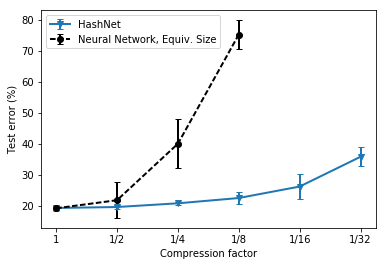

In [171]:
# Plot comparison between hashed and equiv size unhashed
x = np.arange(len(compression_factors_hashed))
plt.xlabel("Compression factor")
plt.ylabel("Test error (%)")
plt.errorbar(x, both_layer_compression_median, both_layer_compression_std, label="HashNet", linewidth=2.0, marker='v', capsize=3)
fig = plt.errorbar(x[:len(compression_factors_base)], base_compression_median, base_compression_std, \
                   label="Neural Network, Equiv. Size", linewidth=2.0, marker='o', linestyle='--', color='black', capsize=3)
plt.xticks(x, ["1", "1/2", "1/4", "1/8", "1/16", "1/32", "1/64", "1/128"])
leg = plt.legend()

In [172]:
with open('compression_equiv.png','wb') as f:
    fig[0].figure.savefig(f, format='png', dpi=144)